In [15]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import statsmodels.tsa.api as smt

# Load and View Data

In [106]:
def load_data():  
    return pd.read_csv('../data/train.csv')  

sales_data = load_data()

In [107]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null object
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [108]:
sales_data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [109]:
def monthly_sales(data):
    monthly_data = data.copy()
    monthly_data.date = monthly_data.date.apply(lambda x: str(x)[:-3])
    monthly_data = monthly_data.groupby('date')['sales'].sum().reset_index()
    monthly_data.date = pd.to_datetime(monthly_data.date)
    return monthly_data

In [110]:
monthly_df = monthly_sales(sales_data)
monthly_df.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


# EDA

In [61]:
# Duration of dataset
def sales_duration(data):
    data.date = pd.to_datetime(data.date)
    number_of_days = data.date.max() - data.date.min()
    number_of_years = number_of_days.days / 365
    print(number_of_days.days, 'days')
    print(number_of_years, 'years')
    
sales_duration(sales_data)

1825 days
5.0 years


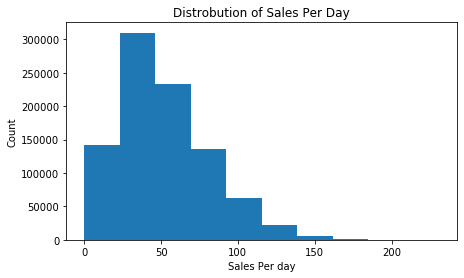

In [83]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(sales_data.sales)
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

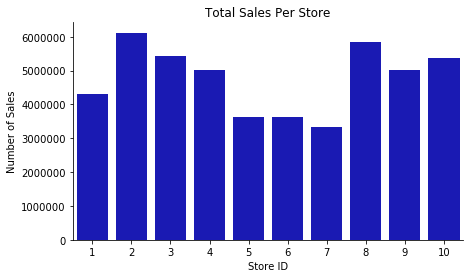

In [94]:
def sales_per_store():
    by_store = sales_data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(7,4))
    sns.barplot(by_store.store, by_store.sales, color='mediumblue')
    
    ax.set(xlabel = "Store ID",
           ylabel = "Number of Sales",
           title = "Total Sales Per Store")
    
    sns.despine()
    
sales_per_store()

In [113]:
# Average monthly sales

# Overall
avg_monthly_sales = monthly_df.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

# Last 12 months (this will be the forecasted sales)
avg_monthly_sales_12month = monthly_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${avg_monthly_sales_12month}")

Overall average monthly sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


# Determining Stationarity

In [111]:
def time_plot(data, x_col, y_col):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax)
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = "Daily Sales: 2013 - 2018")
    
    sns.despine()

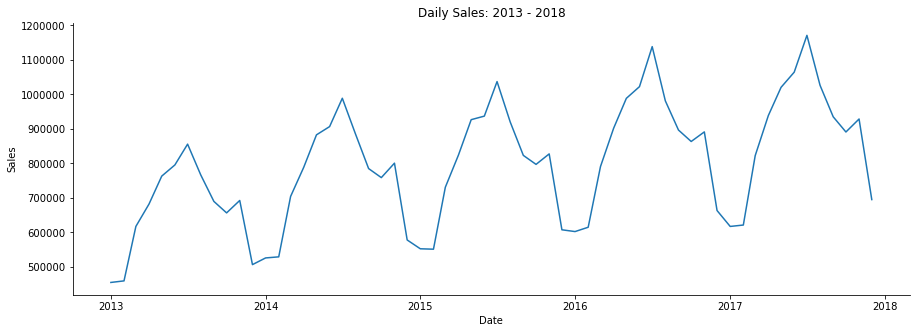

In [112]:
time_plot(monthly_df, 'date', 'sales')

In [11]:
def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv('../data/stationary_df.csv')
    return data

In [12]:
stationary_df = get_diff(monthly_df)

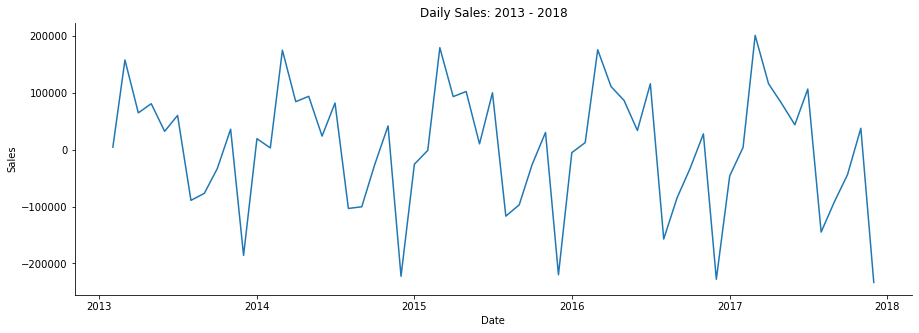

In [13]:
time_plot(stationary_df, 'date', 'sales_diff')

# Observing Lags

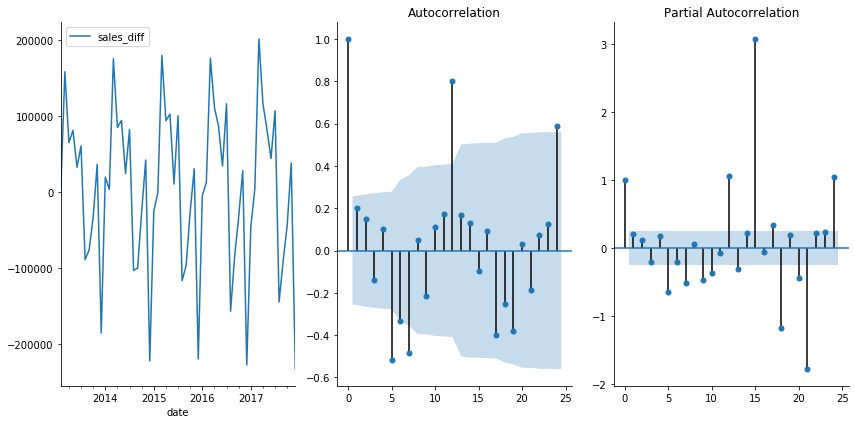

In [28]:
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=24);

# Preparing Dataset Modeling

## Regressive Modeling

In [17]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1,13):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['sales_diff'].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    
    supervised_df.to_csv('../data/model_df.csv', index=False)
    
    return supervised_df

In [18]:
model_df = generate_supervised(stationary_df)

## ARIMA Modeling

In [33]:
def generate_arima_data(data):
    dt_data = data.set_index('date').drop('sales', axis=1)
    dt_data.dropna(axis=0)
    
    dt_data.to_csv('../data/arima_df.csv')
    
    return dt_data

In [34]:
datetime_df = generate_arima_data(stationary_df)